In [1]:
import numpy as np
import tensorflow as tf
from keras import layers, Input, Model, Sequential, optimizers
from keras.layers import Reshape, Merge, Lambda
from keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
import keras.backend as K
from keras.engine import Layer
from keras.utils import multi_gpu_model, np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

#checkpoint = ModelCheckpoint('seg.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='max')
#earlystop = EarlyStopping(monitor='val_loss', patience=5, mode='max')
#callback_list = [earlystop]

GPU_MEMORY_FRACTION = 1.0
DATA_SHAPE = 224
# hyparameters to tune
BATCH_SIZE = 240
LEARNING_RATE = 1e-4
EPOCHS = 20
CLASS_WEIGHT = np.array([1,20])

def segnet(shape=224):
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    model = Sequential()
    model.add(Layer(input_shape=(shape , shape ,3)))
    # encoder
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(filter_size, (kernel, kernel), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(128, (kernel, kernel), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(256, (kernel, kernel), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(512, (kernel, kernel), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # decoder
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(512, (kernel, kernel), padding='valid'))
    model.add( BatchNormalization())
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(256, (kernel, kernel), padding='valid'))
    model.add( BatchNormalization())
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(128, (kernel, kernel), padding='valid'))
    model.add( BatchNormalization())
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(filter_size, (kernel, kernel), padding='valid'))
    model.add( BatchNormalization())
    model.add(Conv2D(2, (1, 1), padding='valid',))
    model.outputHeight = model.output_shape[-2]
    model.outputWidth = model.output_shape[-3] 
    model.add(Activation('softmax'))
    return model

def config_keras_backend(fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = fraction 
    sess = tf.Session(config=config)
    K.set_session(sess)
    
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss
    
    
if __name__ == '__main__':
    print("********** loading labels **********")
    train_labels = np.load('/home/mc16/pre_data/train_label_%s.npy'%DATA_SHAPE)
    val_labels = np.load('/home/mc16/pre_data/val_label_%s.npy'%DATA_SHAPE)
    
    print("********** loading images **********")
    train_images = np.load('/home/mc16/pre_data/train_image_%s.npy'%DATA_SHAPE)
    val_images = np.load('/home/mc16/pre_data/val_image_%s.npy'%DATA_SHAPE)
    
    print("********** building model **********")
    config_keras_backend(GPU_MEMORY_FRACTION)
    seg = segnet(DATA_SHAPE)
    parallel_seg = multi_gpu_model(seg,gpus=8)
    
    print('********** training... **********')
    loss = weighted_categorical_crossentropy(CLASS_WEIGHT)
    adam = Adam(lr=LEARNING_RATE)
    parallel_seg.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    parallel_seg.fit(x = train_images, 
                         y = train_labels,
                         batch_size = BATCH_SIZE,
                         epochs = EPOCHS,
                         verbose = 1,
                         validation_data = (val_images, val_labels),
                         shuffle = True)
    print('********** saveing mdoel **********')
    seg.save('seg_1.h5')

Using TensorFlow backend.


********** loading labels **********
********** loading images **********
********** building model **********
********** training... **********
Train on 20000 samples, validate on 2015 samples
Epoch 1/20
20000/20000 [==============================] - 103s 5ms/step - loss: 0.9514 - acc: 0.5521 - val_loss: 0.9041 - val_acc: 0.6629
Epoch 2/20
20000/20000 [==============================] - 86s 4ms/step - loss: 0.8361 - acc: 0.6499 - val_loss: 0.7870 - val_acc: 0.8129
Epoch 3/20
20000/20000 [==============================] - 88s 4ms/step - loss: 0.7781 - acc: 0.7104 - val_loss: 0.7613 - val_acc: 0.8077
Epoch 4/20
20000/20000 [==============================] - 89s 4ms/step - loss: 0.7297 - acc: 0.7553 - val_loss: 0.7185 - val_acc: 0.8354
Epoch 5/20
20000/20000 [==============================] - 88s 4ms/step - loss: 0.6893 - acc: 0.7872 - val_loss: 0.7057 - val_acc: 0.7536
Epoch 6/20
20000/20000 [==============================] - 87s 4ms/step - loss: 0.6530 - acc: 0.8124 - val_loss: 0.6473 -

In [4]:
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import random
from keras.models import model_from_json
from keras.models import load_model
import keras.backend as K

GPU_MEMORY_FRACTION = 0.05
def config_keras_backend(fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = fraction 
    sess = tf.Session(config=config)
    K.set_session(sess)
    
config_keras_backend(GPU_MEMORY_FRACTION)
model = load_model('seg0608.h5')

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

def crf_image(img, model):
    img = cv2.resize(img, (DATA_SHAPE, DATA_SHAPE))
    score = model.predict(np.expand_dims(img,axis=0))
    softmax = score[0].transpose((2, 0, 1)) # [channel,shap,shape]
    # The input should be the negative of the logarithm of probability values
    # Look up the definition of the softmax_to_unary for more information
    unary = unary_from_softmax(softmax)
    # The inputs should be C-continious -- we are using Cython wrapper
    unary = np.ascontiguousarray(unary)#(2,n)
    crf = dcrf.DenseCRF(img.shape[0] * img.shape[1], 2)
    crf.setUnaryEnergy(unary)

    # This potential penalizes small pieces of segmentation that are
    # spatially isolated -- enforces more spatially consistent segmentations
    feats = create_pairwise_gaussian(sdims=(3,5), shape=img.shape[:2])
    crf.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This creates the color-dependent features --
    # because the segmentation that we get from CNN are too coarse
    # and we can use local color features to refine them
    feats = create_pairwise_bilateral(sdims=(50,50), schan=(20, 20, 20), img=img, chdim=2)
    crf.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # mean field iteration
    Q = crf.inference(1)
    
    res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    return res    

Using TensorFlow backend.


InternalError: Failed to create session.

In [50]:
import random
import numpy as np

def read_paths(dataset_path, list_path):
    imagepaths = []
    labelpaths = []
    for path in tqdm(open(list_path)):
        md5 = path.split('.')[0]
        imagepaths.append(dataset_path + "images/%s.jpg"%md5)
        labelpaths.append(dataset_path + "spline_labels/%s.json"%md5)
    return imagepaths, labelpaths

# detect points for one image
def detect_points(img, model, shape):
    img = cv2.resize(img, (shape,shape))
    img = np.expand_dims(img,axis=0)
    points_logist = model.predict(img)
    points = np.argmax(points_logist, axis=-1)
    return points[0]

val_set_path = '/data/mc_data/MLDC/data/val/'
val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_image_paths, val_label_paths = read_paths(val_set_path, val_list_path)


2015it [00:00, 246997.77it/s]


In [51]:
DATA_SHAPE = 224
train_labels = np.load('/home/mc16/pre_data/train_label_%s.npy'%DATA_SHAPE)
val_labels = np.load('/home/mc16/pre_data/val_label_%s.npy'%DATA_SHAPE)
train_images = np.load('/home/mc16/pre_data/train_image_%s.npy'%DATA_SHAPE)
val_images = np.load('/home/mc16/pre_data/val_image_%s.npy'%DATA_SHAPE)

In [3]:
test_index = random.randint(0, len(val_labels))
# test_index = 100
test_label = val_labels[test_index,:,:,1]
test_img = plt.imread(val_image_paths[test_index])
test_img = cv2.resize(test_img,(DATA_SHAPE,DATA_SHAPE))
test_mask = crf_image(test_img, model)
test_points = detect_points(test_img, model, DATA_SHAPE)
fig, axs = plt.subplots(1, 4, figsize=(30,30)) 
axs[0].imshow(test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(test_points,cmap='gray')
axs[3].imshow(test_mask,cmap='gray')
plt.show()

NameError: name 'random' is not defined

In [2]:
test_mask = crf_image(test_img, model)
test_points = detect_points(test_img, model, DATA_SHAPE)
fig, axs = plt.subplots(1, 4, figsize=(30,30)) 
axs[0].imshow(test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(test_points,cmap='gray')
axs[3].imshow(test_mask,cmap='gray')
plt.show()

NameError: name 'crf_image' is not defined

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import os
import json
from tqdm import tqdm
import random

%matplotlib inline
DATA_SHAPE = 224

# val_labels = np.load('/home/mc16/pre_data/val_label_%s.npy'%DATA_SHAPE)
# val_detect_points = np.load('/home/mc16/result/val_masks_06-11-18:34:58.npy')
# test_detect_points = np.load('/home/mc16/result/test_masks_06-11-18:34:33.npy')

# points in one image
def matrix_to_point(detect_points):
    points_list = []
    for x in range(detect_points.shape[0]):
        for y in range(detect_points.shape[1]):
            if(detect_points[x][y] == 1):
                points_list.append([x, y])
    return np.array(points_list)
val_point_data = matrix_to_point(test_points)

# cluster in one image
def get_cluster_points(points, EPS = 1.5, MIN_SAMPLES = 3):
    if points == []: 
        cluster_points = []
    else:
        arpoints = np.array(points)
        cluster_label = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit_predict(arpoints)
        max_label = np.max(cluster_label)
        cluster_points = []
        for label in range(-1, max_label+1):
            label_index = np.where(cluster_label == label)
            cluster_points.append(arpoints[label_index])
    return cluster_points
val_cluster_list = get_cluster_points(val_point_data, EPS = 1.5, MIN_SAMPLES = 3)

def cluster_to_img(cluster_points, shape):
    pic = np.zeros((shape, shape), np.uint8)
    num_label = cluster_points.shape[0]
    for i in range(num_label):
        for point in cluster_points[i]:
            pic[point[0], point[1]] = i * int(255 / num_label)
    return pic

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


169.0
0.87266463
171.0
0.8901179
173.0
0.9075712
167.0
0.8552113
175.0
0.9250245
165.0
0.83775806
163.0
0.82030475
177.0
0.94247776


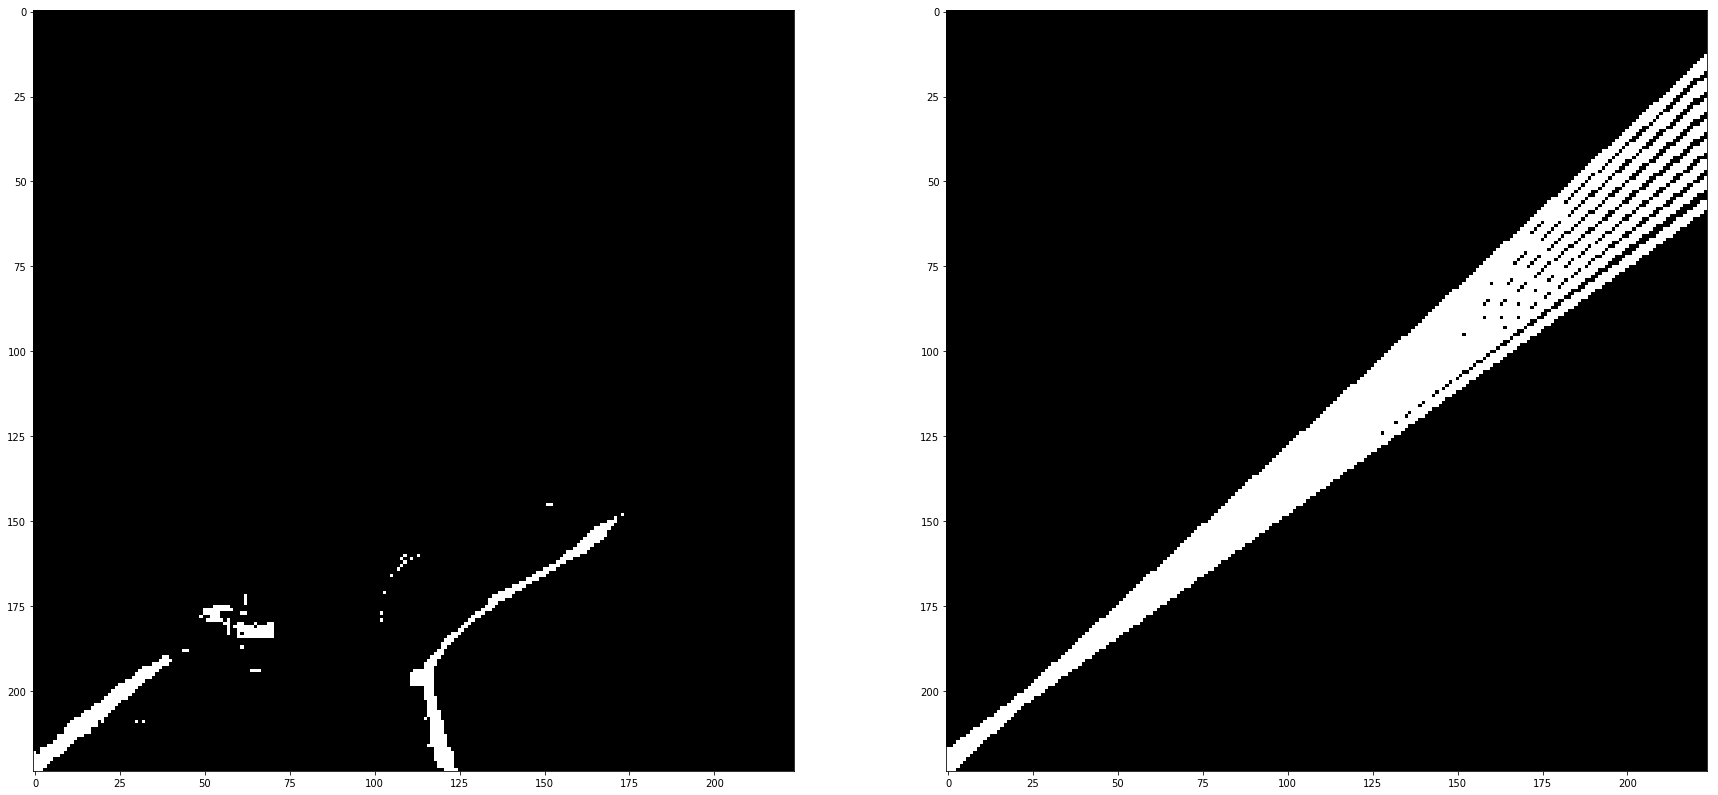

In [80]:
import cv2
import numpy as np
val_h = np.load('/home/mc16/result/val_fit_06-13-02:27:32.npy')
val_masks = np.load('/home/mc16/result/val_masks_06-12-00:43:14.npy')

test_index = 100

test_mask = val_masks[test_index]

h_lines = val_h[test_index][:]
#edges = cv2.Canny(h_lines, 50,200)
lines = cv2.HoughLines(test_mask, 2, np.pi/180, 100)
#print(lines[0])


#def draw_hough(lines):
pic = np.zeros((224,224), dtype=np.uint8)
    #if(len(lines) == 0):
    #    return pic
    #for rho,theta in lines[0]:
for line in lines[0]:
    rho = line[0]
    theta = line[1]
    print(rho)
    print(theta)
    if theta<(np.pi/4.) or theta>(3.*np.pi/4.0):
        pt1=(int(rho/np.cos(theta)),0)
    a=np.cos(theta)
    b=np.sin(theta)
    x0=a*rho
    y0=b*rho
    x1=int(x0+1000*(-b))
    y1=int(y0+1000*(a))
    x2=int(x0-1000*(-b))
    y2=int(y0-1000*(a))
    cv2.line(pic,(x1,y1),(x2,y2),255,2)
    #return pic

fig, axs = plt.subplots(1, 2, figsize=(30,30)) 
axs[0].imshow(test_mask,cmap='gray')
hough_img = draw_hough(lines)
axs[1].imshow(hough_img,cmap='gray')
# axs[2].imshow(test_points,cmap='gray')
plt.show()

In [89]:
DATA_SHAPE = 224
train_images = np.load('/home/mc16/pre_data/train_image_%s.npy'%DATA_SHAPE)
val_images = np.load('/home/mc16/pre_data/val_image_%s.npy'%DATA_SHAPE)
train_images = np.concatenate((train_images,val_images),axis=0)
train_images.shape

(22015, 224, 224, 3)